In [1]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from src.models_RNN import RNNDataset, collate_fn

# ==================================
# 1. Load and Preprocess Data
# ==================================

# Load data
site_df = pd.read_csv('data/abcd_y_lt.csv').iloc[:, [0, 2, 7]]
traindata = pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv')

# Remove cbcl-related columns
traindata = traindata.loc[:, ~traindata.columns.str.startswith("cbcl")]
testdata = testdata.loc[:, ~testdata.columns.str.startswith("cbcl")]

# Columns to exclude from features
lostcolumns = ["interview_date", "site", "src_subject_id", "y_t", "y_{t+1}", "eventname", "race_ethnicity", "urban"]

# Convert interview_date to datetime
for df in [site_df, traindata, testdata]:
    df['interview_date'] = pd.to_datetime(df['interview_date'], errors='coerce')

# Clean site ID
site_df['site_id_l'] = site_df['site_id_l'].str[4:].astype(int)

# Build subject-date to site mapping
subject_date_site_mapping = (
    site_df.groupby('src_subject_id')
    .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
    .to_dict()
)

# Function to map site
def get_site(row):
    subject_id = row['src_subject_id']
    interview_date = row['interview_date']
    return subject_date_site_mapping.get(subject_id, {}).get(interview_date, None)

# Load urban info
df_urban = pd.read_csv("data/led_l_urban.csv")

# Apply site and urban mapping
for df in [traindata, testdata]:
    df['site'] = df.apply(get_site, axis=1)
    df.insert(1, 'site', df.pop('site'))
    df = df.merge(df_urban[['src_subject_id', 'reshist_addr1_urban_area']], on='src_subject_id', how='left')
    df.insert(1, 'urban', df.pop('reshist_addr1_urban_area'))

top_vars = [x for x in testdata.columns if x not in lostcolumns]

# Convert everything to numeric
for col in top_vars:
    traindata[col] = pd.to_numeric(traindata[col], errors='coerce')

for col in top_vars:
    testdata[col] = pd.to_numeric(testdata[col], errors='coerce')

# Feature columns

# Create race indicator columns
for df in [traindata, testdata]:
    df['white'] = (df['race_ethnicity'] == 1).astype(int)
    df['black'] = (df['race_ethnicity'] == 2).astype(int)
    df['hispano'] = (df['race_ethnicity'] == 3).astype(int)
    df['asian'] = (df['race_ethnicity'] == 4).astype(int)
    df['others'] = (df['race_ethnicity'] == 5).astype(int)


# ==================================
# 2. Split train/validation subjects
# ==================================

# Only keep subjects with more than 1 record
# Only keep subjects with at least 2 records
grouped = traindata.groupby('src_subject_id')
valid_subjects = [name for name, group in grouped if len(group) > 1]

if len(valid_subjects) == 0:
    raise ValueError("No valid subjects with more than 1 record found!")

# Filter data
traindata = traindata[traindata['src_subject_id'].isin(valid_subjects)]

# Now split
train_subjects, val_subjects = train_test_split(valid_subjects, test_size=0.2, random_state=42)

# Create train and validation datasets
train_data = traindata[traindata['src_subject_id'].isin(train_subjects)]
hatdata = traindata[traindata['src_subject_id'].isin(val_subjects)]

data_test = testdata

# ==================================
# 3. Create sequence datasets
# ==================================

def create_sequences(df, feature_cols):
    grouped = df.groupby('src_subject_id')
    X_seqs, y_seqs, subject_ids = [], [], []
    for subject_id, group in grouped:
        group = group.sort_values("interview_date")
        X = group[feature_cols].values
        y = group["y_{t+1}"].values
        if len(X) > 1:
            X_seqs.append(torch.tensor(X, dtype=torch.float32))
            y_seqs.append(torch.tensor(y, dtype=torch.float32))
            subject_ids.append(subject_id)  
    return X_seqs, y_seqs, subject_ids
train_X, train_y, train_subjects_id = create_sequences(train_data, top_vars)
val_X, val_y, val_subjects_id = create_sequences(hatdata, top_vars)
test_X, test_y, test_subjects_id = create_sequences(data_test, top_vars)

# ==================================
# 4. Define Dataset and DataLoader
# ==================================



# Create DataLoaders
batch_size = 16
train_loader = DataLoader(RNNDataset(train_X, train_y,train_subjects_id), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(RNNDataset(val_X, val_y, val_subjects_id), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(RNNDataset(test_X, test_y, test_subjects_id), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_13748/3028778695.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_13748/3028778695.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [5]:
from src.models_RNN import TraditionalLSTMMethod, RegularizationLSTMMethod, DROLSTMMethod, tune_lstm_model_with_optuna_whole
# Set random seeds
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# =======================
# Define Parameter Ranges
# =======================

trad_param_ranges = {
    "hidden_dim": {"type": "int", "low": 128, "high": 192, "step": 16},
}
trad_fixed_params = {
    "learning_rate": 0.01,
    "dropout": 0.3,
    "num_epochs": 10000,
}

reg_param_ranges = {
    "hidden_dim": {"type": "int", "low": 128, "high": 192, "step": 16},
    "lambda_val": {"type": "float", "low": 1e-5, "high": 0.001, "log": True},
}
reg_fixed_params = {
    "learning_rate": 0.01,
    "dropout": 0.3,
    "num_epochs": 10000,
}

dro_param_ranges = {
    "hidden_dim": {"type": "int", "low": 128, "high": 192, "step": 32},
    "kappa": {"type": "float", "low": 1e-7, "high": 5e-5, "log": True},
}
dro_fixed_params = {
    "learning_rate": 0.01,
    "dropout": 0.3,
    "num_epochs": 10000,
    "kappacoef": 1.0,
    "wasserstein": 40.0,
}

# =======================
# Train and Tune Each Method
# =======================

print("Tuning Traditional LSTM (Whole Data)")
(trad_model, trad_results), trad_study = tune_lstm_model_with_optuna_whole(
    TraditionalLSTMMethod,
    train_loader,  # Pass DataLoader instead of X_train
    val_loader,    # Pass DataLoader instead of hatdata
    test_loader,   # Pass DataLoader instead of data_test
    param_ranges=trad_param_ranges,
    fixed_params=trad_fixed_params,
    n_trials=10
)

print("Tuning Regularization LSTM (Whole Data)")
(reg_model, reg_results), reg_study = tune_lstm_model_with_optuna_whole(
    RegularizationLSTMMethod,
    train_loader,
    val_loader,
    test_loader,
    param_ranges=reg_param_ranges,
    fixed_params=reg_fixed_params,
    n_trials=40
)

print("Tuning DRO LSTM (Whole Data)")
(dro_model, dro_results), dro_study = tune_lstm_model_with_optuna_whole(
    DROLSTMMethod,
    train_loader,
    val_loader,
    test_loader,
    param_ranges=dro_param_ranges,
    fixed_params=dro_fixed_params,
    n_trials=60
)

# =======================
# Summary
# =======================
print("================== Summary ==================")
print("Best Validation AUCs (on validation set):")
print("Traditional LSTM:", trad_study.best_value)
print("Regularization LSTM:", reg_study.best_value)
print("DRO LSTM:", dro_study.best_value)

print("\nWhole Test Set AUCs:")
print("Traditional LSTM:", trad_results["auc_all"])
print("Regularization LSTM:", reg_results["auc_all"])
print("DRO LSTM:", dro_results["auc_all"])



Tuning Traditional LSTM (Whole Data)
[Final Whole Test Results]
Best Validation AUC: 0.809710367429547
Final Test AUC: 0.6205382865202014
Tuning Regularization LSTM (Whole Data)
[Final Whole Test Results]
Best Validation AUC: 0.8308443566050058
Final Test AUC: 0.7978154588374914
Tuning DRO LSTM (Whole Data)
[Final Whole Test Results]
Best Validation AUC: 0.8248429581086781
Final Test AUC: 0.6473531016080228
================== Summary ==================
Best Validation AUCs (on validation set):
Traditional LSTM: 0.809710367429547
Regularization LSTM: 0.8308443566050058
DRO LSTM: 0.8248429581086781

Whole Test Set AUCs:
Traditional LSTM: 0.6205382865202014
Regularization LSTM: 0.7978154588374914
DRO LSTM: 0.6473531016080228


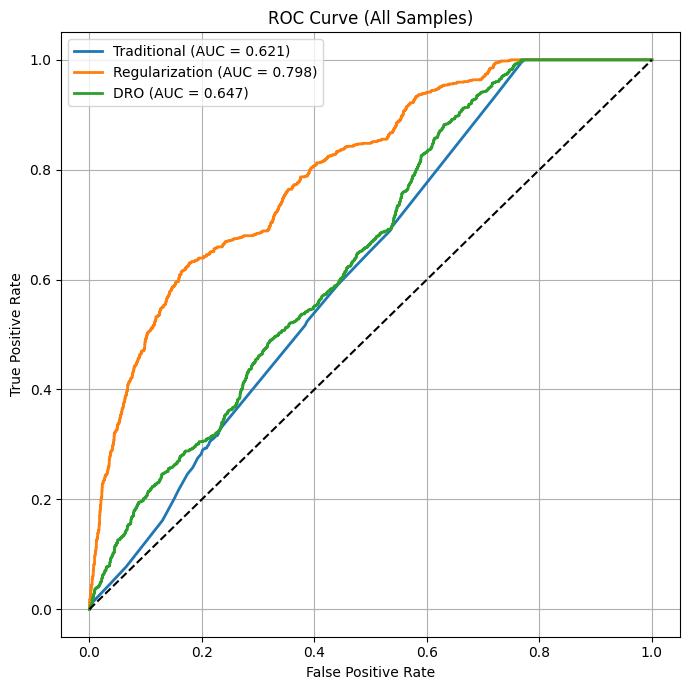

/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


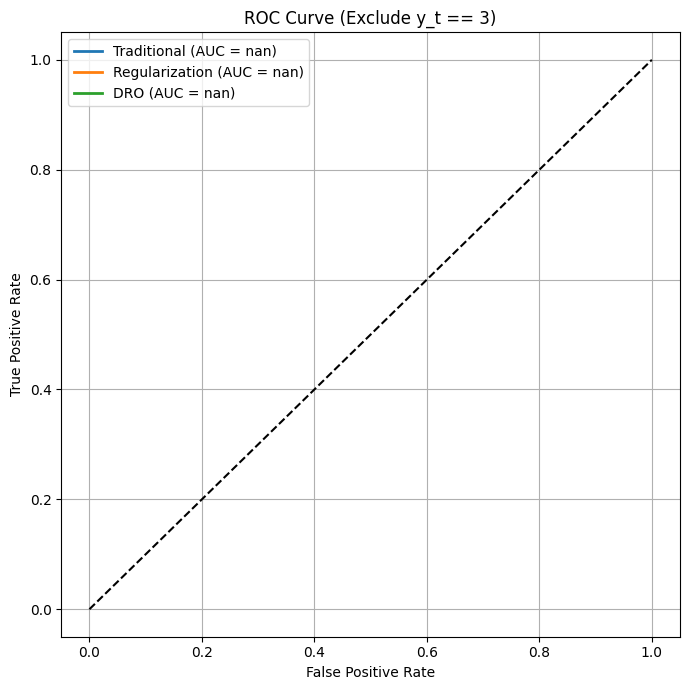

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

trad_probs = trad_results["prob_all"]
reg_probs = reg_results["prob_all"]
dro_probs = dro_results["prob_all"]

trad_targets = trad_results["targets_all"]
reg_targets = reg_results["targets_all"]
dro_targets = dro_results["targets_all"]

# 只保留 targets != -100 的
valid_mask_trad = trad_targets != -100
valid_mask_reg = reg_targets != -100
valid_mask_dro = dro_targets != -100

# ➔ 统一mask
trad_probs = trad_probs[valid_mask_trad]
reg_probs = reg_probs[valid_mask_reg]
dro_probs = dro_probs[valid_mask_dro]

trad_targets = trad_targets[valid_mask_trad]
reg_targets = reg_targets[valid_mask_reg]
dro_targets = dro_targets[valid_mask_dro]

# Binary labels: (y == 3)
y_true_trad = (trad_targets == 3).astype(int)
y_true_reg = (reg_targets == 3).astype(int)
y_true_dro = (dro_targets == 3).astype(int)

# 画图 - All samples
fpr_trad, tpr_trad, _ = roc_curve(y_true_trad, trad_probs)
auc_trad = auc(fpr_trad, tpr_trad)

fpr_reg, tpr_reg, _ = roc_curve(y_true_reg, reg_probs)
auc_reg = auc(fpr_reg, tpr_reg)

fpr_dro, tpr_dro, _ = roc_curve(y_true_dro, dro_probs)
auc_dro = auc(fpr_dro, tpr_dro)

plt.figure(figsize=(7, 7))
plt.plot(fpr_trad, tpr_trad, label=f"Traditional (AUC = {auc_trad:.3f})", linewidth=2)
plt.plot(fpr_reg, tpr_reg, label=f"Regularization (AUC = {auc_reg:.3f})", linewidth=2)
plt.plot(fpr_dro, tpr_dro, label=f"DRO (AUC = {auc_dro:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (All Samples)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exclude y_t == 3
keep_trad = trad_targets != 3
keep_reg = reg_targets != 3
keep_dro = dro_targets != 3

fpr_trad, tpr_trad, _ = roc_curve(y_true_trad[keep_trad], trad_probs[keep_trad])
auc_trad = auc(fpr_trad, tpr_trad)

fpr_reg, tpr_reg, _ = roc_curve(y_true_reg[keep_reg], reg_probs[keep_reg])
auc_reg = auc(fpr_reg, tpr_reg)

fpr_dro, tpr_dro, _ = roc_curve(y_true_dro[keep_dro], dro_probs[keep_dro])
auc_dro = auc(fpr_dro, tpr_dro)

plt.figure(figsize=(7, 7))
plt.plot(fpr_trad, tpr_trad, label=f"Traditional (AUC = {auc_trad:.3f})", linewidth=2)
plt.plot(fpr_reg, tpr_reg, label=f"Regularization (AUC = {auc_reg:.3f})", linewidth=2)
plt.plot(fpr_dro, tpr_dro, label=f"DRO (AUC = {auc_dro:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Exclude y_t == 3)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
print(f"Number of samples used for ROC: {len(y_true_trad)}")
print(f"y_true counts:", np.bincount(y_true_trad))


Number of samples used for ROC: 4420
y_true counts: [3486  934]


In [15]:
trad_results["subject_ids"]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,